In [1]:
import torch
import warnings
import os
import wandb

warnings.simplefilter("ignore", UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset.data_loaders import dataset_for_deepar
from pytorch_forecasting import DeepAR

from pytorch_forecasting.metrics import NormalDistributionLoss
from inference.bayesian.utils import plot_forecast
from inference.inference import inference

c:\Users\mgphy\Anaconda3\envs\uncertainty_pf\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
config = {
            "dataset": "acea",
            "inference": "deepar",
            "num_iterations": 50,
            "num_samples": 100,
            "sweep": True,
            "plot": True
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
training, train_dataloader, val_dataloader, test_dataloader, horizon = dataset_for_deepar(config.dataset)

In [5]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [6]:
model = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=32,
    rnn_layers=2,
    loss=NormalDistributionLoss(),
    optimizer="Adam",
)

In [8]:
predictive, diagnostics = inference(config, model, None,
                                    X_train=train_dataloader, Y_train=None, 
                                    X_val=val_dataloader, Y_val=None,
                                    X_test=test_dataloader, Y_test=None,
                                    quantiles=quantiles,
                                    horizon=24)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 1     
3 | rnn                    | LSTM                   | 13.8 K
4 | distribution_projector | Linear                 | 66    
------------------------------------------------------------------
13.9 K    Trainable params
0         Non-trainable params
13.9 K    Total params
0.056     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s, v_num=103, train_loss_step=2.460, val_loss=2.520, train_loss_epoch=2.630]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s, v_num=103, train_loss_step=2.460, val_loss=2.520, train_loss_epoch=2.630]


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor([[71.9250, 71.5000, 66.5250, 70.7250, 70.3750, 78.4000, 91.1750, 98.1250,
         96.4750, 80.7500, 75.0500, 63.8500, 52.9500, 42.2250, 39.2000, 35.8000,
         36.2500, 36.1500, 40.5500, 51.7750, 59.4750, 65.7000, 75.7250, 75.7000]])


<Figure size 600x600 with 0 Axes>

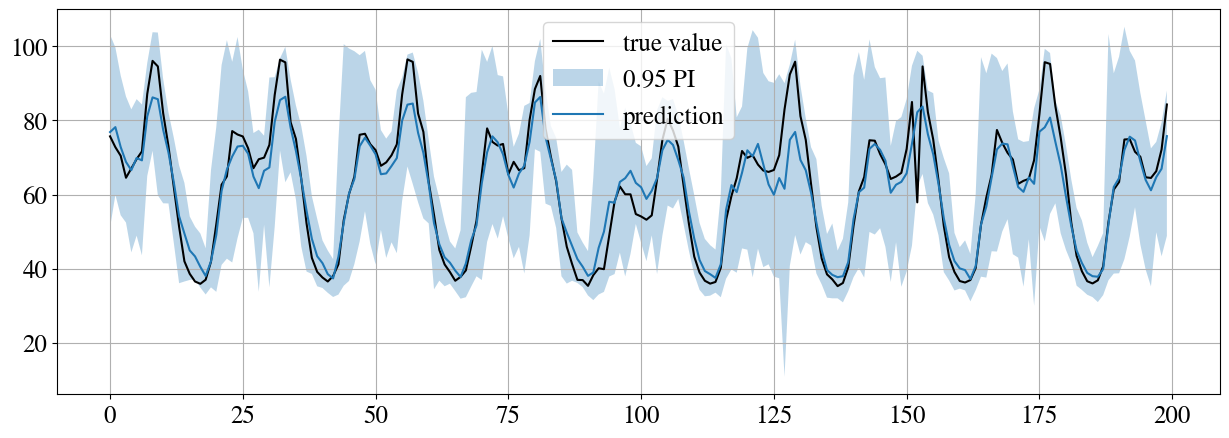

In [9]:
CI = [diagnostics["quantiles"][2], diagnostics["quantiles"][-2]]

plot_forecast(predictive, predictive["y"], None, np.zeros(shape=(predictive['obs'].shape[1])), CI, "deepar", 200)

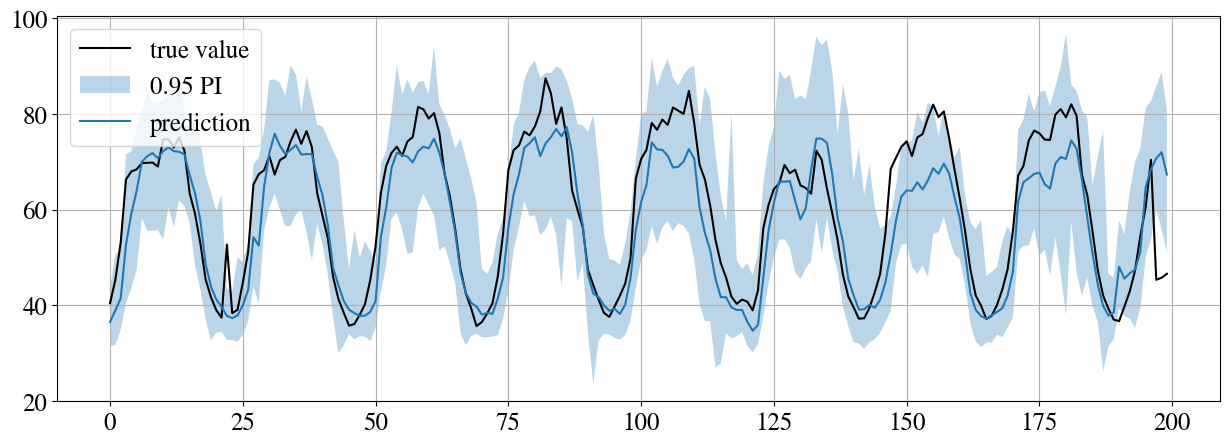

In [123]:
CI = [diagnostics["new_quantiles"][2], diagnostics["new_quantiles"][-2]]

plot_forecast(predictive, predictive["y"], None, np.zeros(shape=(predictive['obs'].shape[1])), CI, "deepar", 200)

In [10]:
for k, v in diagnostics.items():
    print(k, "\t", v)

train_time 	 820.625
final_loss 	 nan
inference_time 	 98.546875
cal_error 	 0.04508731627930634
new_cal_error 	 0.011034912744022452
quantiles 	 [0, 0.005, 0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4, 0.42500000000000004, 0.45, 0.47500000000000003, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6000000000000001, 0.625, 0.65, 0.675, 0.7000000000000001, 0.7250000000000001, 0.75, 0.775, 0.8, 0.8250000000000001, 0.8500000000000001, 0.875, 0.9, 0.925, 0.9500000000000001, 0.9750000000000001, 0.995]
new_quantiles 	 [0.         0.         0.0300875  0.06590278 0.10112723 0.13377119
 0.16949728 0.19663851 0.22261444 0.24907143 0.27385833 0.3033179
 0.32640179 0.35285211 0.37861378 0.40206944 0.42267361 0.45220779
 0.47605718 0.49578457 0.5165696  0.53569712 0.55412219 0.57495787
 0.5975686  0.61760638 0.6415625  0.66404167 0.68612981 0.71043919
 0.73483386 0.75729167 0.7786